## Isochrone Fitting for Quinn's Photometry

In [2]:
import numpy as np
import pandas as pd
import astropy.io.fits as pf
from astropy.table import Table
import matplotlib.pyplot as plt
import photutils as ph
import astropy.units as u
import astropy.constants as c
import glob
import os

In [ ]:
# read in quinn's photometry

photomet = glob.glob('/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/*.csv')


In [29]:
photomet

['/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/coma_berenices_phot.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/bootes_err.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/leo_err.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/leo_phot.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/hercules_err.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/canes_venatici_phot.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/ursa_major_err.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/ursa_major_phot.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/coma_berenices_err.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/photometry/bootes_phot.csv',
 '/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3

In [34]:
photom = {}
photom_err = {}
for i,file in enumerate(photomet):
    if 'err' in file:
        dwarf = os.path.splitext(os.path.basename(file))[0][:-4]
        photom_err[dwarf] = pd.read_csv(file)
    else:
        dwarf = os.path.splitext(os.path.basename(file))[0][:-5]
        photom[dwarf] = pd.read_csv(file)

In [180]:
def read_dsep(filename, dm):

    dsep_txt = np.genfromtxt(filename, dtype=float, comments='#', unpack=True)
    dsep_g = dsep_txt[10]
    dsep_r = dsep_txt[15]

    dsep = pd.DataFrame({'g':dsep_g, 'r':dsep_r})
    dsep['gr'] = dsep['g'] - dsep['r']
    dsep['y'] = dsep['r'] + dm

    return dsep

In [181]:
5*np.log10(0.1e6) - 5

20.0

In [201]:
isochrones = {}

isos = glob.glob('/Users/f006zcq/Desktop/Dartmouth/SP25/A118/A118-Assign3/data/isochrones/DSEP/10-12Gyr/*-15.iso')

for i,iso in enumerate(isos):
    file = os.path.splitext(os.path.basename(iso))[0]
    for dmod in np.arange(20,25):
        dseps = read_dsep(iso,dmod)
        isochrones[file+str(dmod)]=dseps

In [202]:
isochrones.keys()

dict_keys(['12Gyr-1520', '12Gyr-1521', '12Gyr-1522', '12Gyr-1523', '12Gyr-1524', '11gyr-1520', '11gyr-1521', '11gyr-1522', '11gyr-1523', '11gyr-1524', '10gyr-1520', '10gyr-1521', '10gyr-1522', '10gyr-1523', '10gyr-1524'])

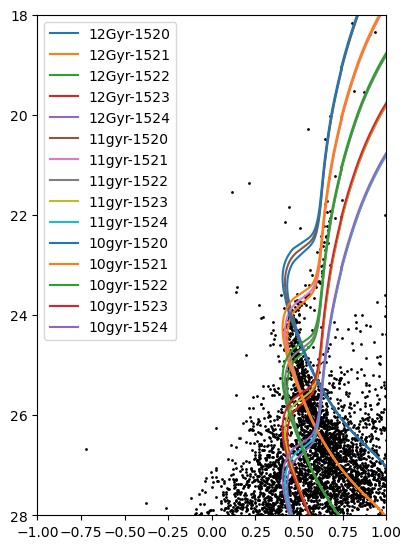

In [203]:
plt.figure(figsize=(4.5,6.5))

for iso in isochrones.keys():
    plt.plot(isochrones[iso]['gr'],isochrones[iso]['y'],label=iso)


plt.scatter(photom['leo']['color'],photom['leo']['f814w'],1,color='k')
plt.legend()
plt.xlim(-1,1)
plt.ylim(18,28)
plt.gca().invert_yaxis()
